# Predicting Airport Taxi Demand: Time Series Forecasting for Peak Hours

Sweet Lift Taxi aims to improve driver availability during peak hours by forecasting taxi demand at airports. This project leverages historical data to build a predictive model that estimates the number of taxi orders for the next hour. 

The scope of this project involves analyzing historical taxi order data collected at airports to develop a predictive model for estimating demand in the next hour. The data will be resampled to hourly intervals, and key time-based features such as lags, rolling averages, and seasonal patterns will be engineered to enhance predictive accuracy. Various forecasting techniques, including Linear Regression, ARIMA, AND ARMA will be explored to identify the most effective model. The performance of these models will be evaluated using the Root Mean Squared Error (RMSE) metric, with a target threshold of 48. The final model will enable Sweet Lift Taxi to anticipate peak demand periods more accurately, allowing for better resource allocation and improved driver availability, ultimately enhancing overall service efficiency.

In [ ]:
# Loading Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor



### Data Preparation & EDA

In [ ]:
# Loading data
df = pd.read_csv('taxi.csv',index_col=['datetime'], parse_dates=['datetime'])
df.sort_index(inplace=True)

In [201]:
# Display basic information and the first few rows
df.info(), df.head()

In [202]:
# Resample data by one-hour intervals, summing sum_orders
df = df.resample('1H').sum()

### Data Analysis

Analyze the dataset for trends, seasonality, and potential missing values before moving to model training

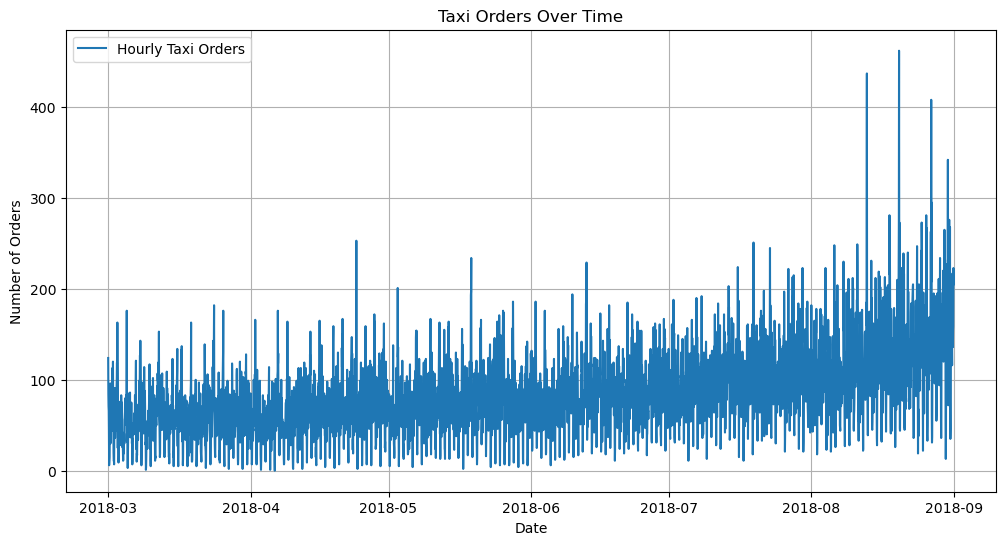

In [203]:
# Check for missing values
missing_values = df.isnull().sum()

# Plot the time series data

plt.figure(figsize=(12,6))
plt.plot(df.index, df['num_orders'], label='Hourly Taxi Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.title('Taxi Orders Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Display missing values count
print("Missing values columns found:", missing_values)

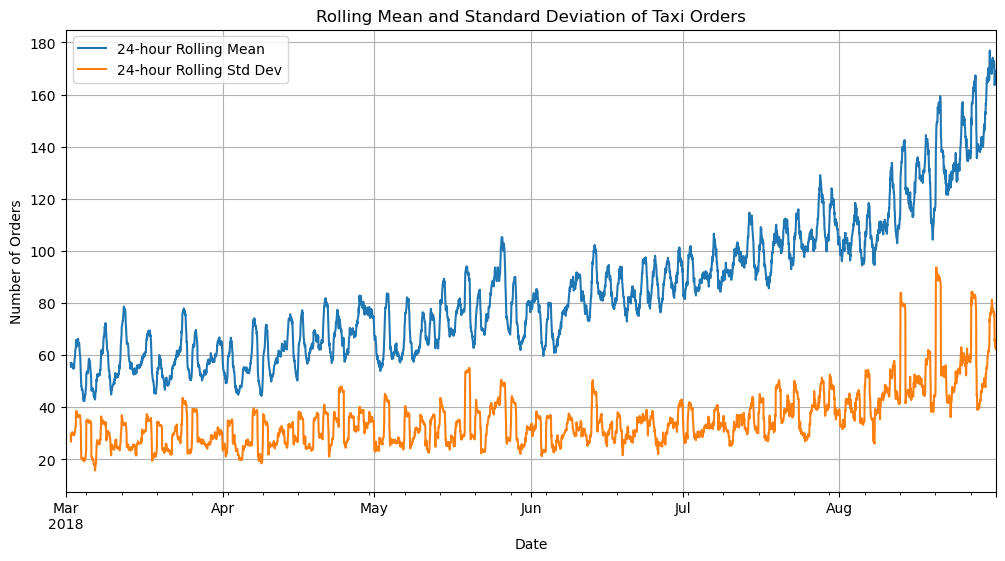

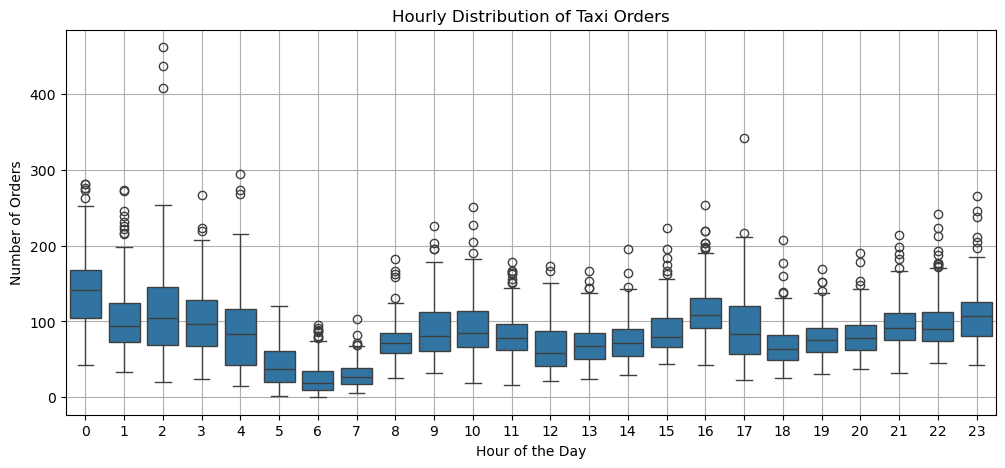

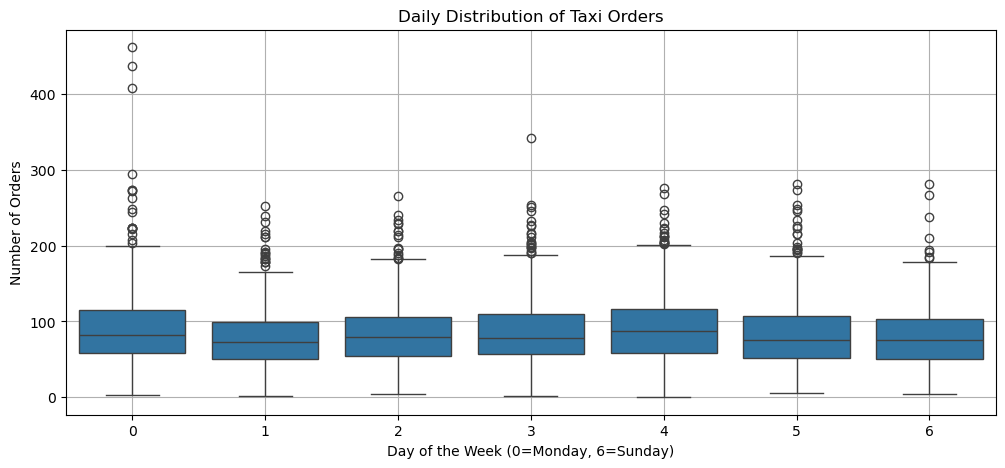

In [204]:
# Plot rolling mean and standard deviation to check trends
plt.figure(figsize=(12,6))
df['num_orders'].rolling(24).mean().plot(label='24-hour Rolling Mean')
df['num_orders'].rolling(24).std().plot(label='24-hour Rolling Std Dev')
plt.legend()
plt.title('Rolling Mean and Standard Deviation of Taxi Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Check for weekly seasonality by plotting average orders by hour of the day and day of the week
df_resampled = df.copy()
df_resampled["hour"] = df_resampled.index.hour
df_resampled["day_of_week"] = df_resampled.index.dayofweek

plt.figure(figsize=(12, 5))
sns.boxplot(x="hour", y="num_orders", data=df_resampled)
plt.title("Hourly Distribution of Taxi Orders")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x="day_of_week", y="num_orders", data=df_resampled)
plt.title("Daily Distribution of Taxi Orders")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.show()

This plot shows the 24-hour rolling mean and standard deviation of taxi orders over time. The rolling mean steadily increases, indicating a long-term upward trend in demand. The rolling standard deviation also rises, especially toward the end of the period, suggesting growing variability in order volume. These patterns confirm both trend and increasing volatility, highlighting the need for models that account for non-stationarity and potentially time-varying variance.

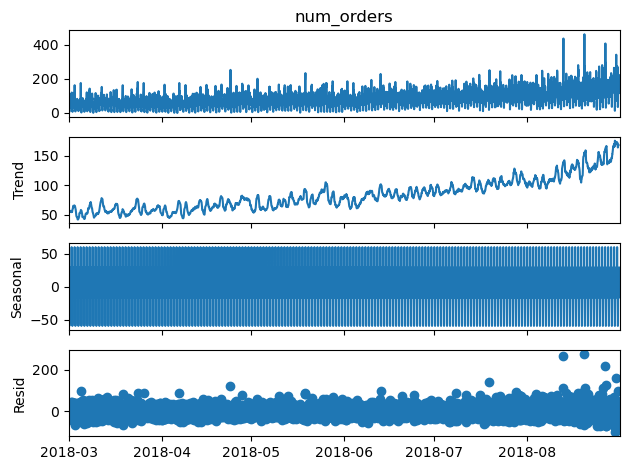

In [205]:
# Decompose the time series
decomposition = seasonal_decompose(df["num_orders"], model="additive", period=24)

# Plot the decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

This time series decomposition plot of num_orders shows a clear upward trend, indicating growing order volume over time. The seasonal component exhibits strong, repetitive daily or weekly patterns, suggesting regular fluctuations. The residuals appear somewhat random but show increasing variance toward the end, which could imply heteroscedasticity. Overall, the series is influenced by both trend and seasonality, so modeling methods like SARIMA or Exponential Smoothing with trend and seasonality may be appropriate.

In [206]:
# Perform ADF test
adf_test = adfuller(df["num_orders"])

# Print results
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")

# Interpretation
if adf_test[1] < 0.05:
    print("The time series is stationary (reject H0).")
else:
    print("The time series is non-stationary (fail to reject H0).")

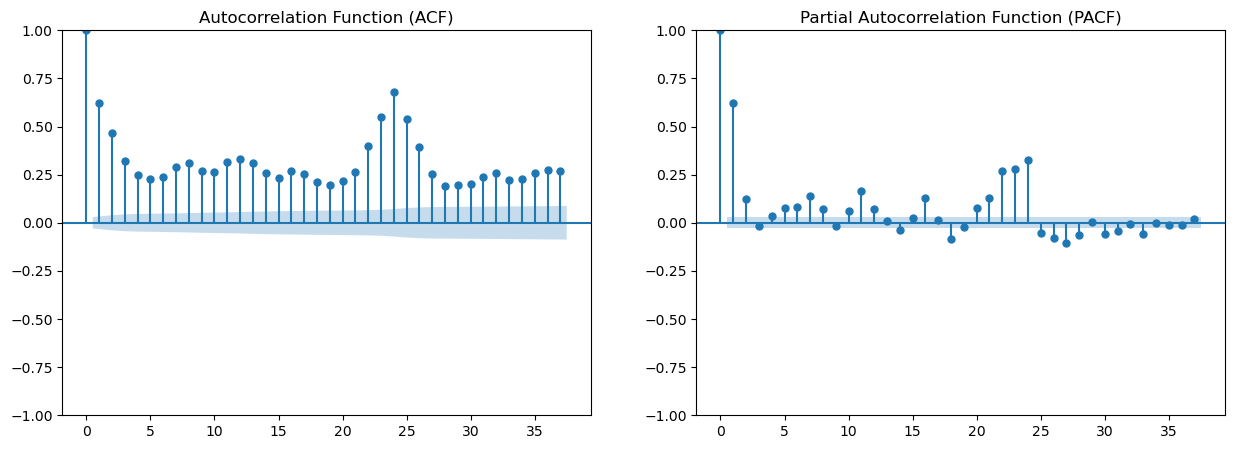

In [207]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df["num_orders"].dropna(), ax=ax[0])
plot_pacf(df["num_orders"].dropna(), ax=ax[1])
ax[0].set_title("Autocorrelation Function (ACF)")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

The ACF plot shows a high autocorrelation at lag 1 with a slow decay, suggesting a possible non-stationary series with persistent correlation. The PACF plot has a strong spike at lag 1 followed by a sharp drop, indicating an AR(1) process. This pattern suggests the data may follow an autoregressive structure and could benefit from differencing to achieve stationarity. A good starting point for modeling might be an ARIMA(1,d,0), with d determined by stationarity tests.

### Models Training

#### Data Preparation & Feature Engineering

In [208]:
# Split data into  80% training, 20% temporary (validation + test)
df_train, df_temp = train_test_split(df, shuffle=False, test_size=0.2)

# Split the temporary set into 50% validation, 50% testing (10% each)
df_valid, df_test = train_test_split(df_temp, shuffle=False, test_size=0.5)

# Display dataset shapes
print("Training set:", df_train.shape)
print("Validation set:", df_valid.shape)
print("Testing set:", df_test.shape)

In [209]:
# Function to create features
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

# Copying dataframe to avoid alteration for feature engineering
train = df_train.copy()
valid = df_valid.copy()
test = df_test.copy()

# Apply feature engineering
make_features(train, max_lag=6, rolling_mean_size=10)
make_features(valid, max_lag=6, rolling_mean_size=10)
make_features(test, max_lag=6, rolling_mean_size=10)

In [210]:
# Drop NAN values caused by shifting
train = train.dropna()
valid = valid.dropna()
test = test.dropna()

In [211]:
# Define features and target
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid= valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [212]:
# # Display dataset shapes
print("Training set:", features_train.shape)
print("Validation set:", features_valid.shape)
print("Testing set:", features_test.shape)

#### Train Multiple Models with Hyperparameter Tuning

**Linear Regression**

In [213]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
pred_lr = lr_model.predict(features_valid)
rmse_lr = np.sqrt(mean_squared_error(target_valid, pred_lr))
print(f"Linear Regression RMSE: {rmse_lr:.2f}")

**GradientBoostingRegressor**

In [ ]:

# Define hyperparameters to tune
gbr_params = {
    'n_estimators': [150,100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
}

gbr = GradientBoostingRegressor(random_state=100)
gbr_grid = GridSearchCV(gbr, gbr_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gbr_grid.fit(features_train, target_train)

gbr_best = gbr_grid.best_estimator_
y_pred_gbr = gbr_best.predict(features_valid)
rmse_gbr = mean_squared_error(target_valid, y_pred_gbr)
print(f"Best GBR RMSE: {rmse_gbr:.2f} with params: {gbr_grid.best_params_}")

**XGBoost**

In [215]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=100)

xgb_params = {
    'n_estimators': [150, 100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [1, 3, 5],
}

xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid.fit(features_train, target_train)

xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(features_valid)
rmse_xgb = mean_squared_error(target_valid, y_pred_xgb)
print(f"Best XGBoost RMSE: {rmse_xgb:.2f} with params: {xgb_grid.best_params_}")

**Ridge Regression**

In [ ]:

# Scale features for Ridge
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

ridge_params = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0]}

ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_grid.fit(features_train, target_train)

ridge_best = ridge_grid.best_estimator_
y_pred_ridge = ridge_best.predict(features_valid)
rmse_ridge = mean_squared_error(target_valid, y_pred_ridge)
print(f"Best Ridge RMSE: {rmse_ridge:.2f} with alpha: {ridge_grid.best_params_}")

**Autoregressive (ARMA) Models**

One of the major assumptions of the ARMA model is that the time series data we feed it is stationary. During analysis, it was found the data set to be stationary where adfuller() function returned a p-Value of 0.03.

In [217]:
# Using the arma_order_select_ic() function to automatically determine the best ARMA(p, q) order based on information criteria AIC

# Find the best (p, q) order using AIC
best_order = arma_order_select_ic(df_train["num_orders"], ic='aic', max_ar=10, max_ma=10)

# Print best ARMA order based on AIC
print("Best ARMA Order (p, q):", best_order.aic_min_order)

# Train ARMA model with selected order (p, q)
p, q = best_order.aic_min_order
arma_model = ARIMA(df_train, order=(p, 0, q)).fit()

# Predict
y_pred_arma = arma_model.predict(
    start=len(df_train), end=len(df_train) + len(df_valid) - 1, dynamic=False)

# Evaluate
rmse_arma = np.sqrt(mean_squared_error(df_valid, y_pred_arma))
print(f"ARMA RMSE: {rmse_arma:.2f}")

**Autoregressive Intergrated Moving Average (ARIMA)**

In [218]:
# Train ARIMA model using auto_arima() to find best possible model
arima_model = auto_arima(df_train, seasonal=False, m=12, scoring='mae')

# Predict
y_pred_arima = arima_model.predict(len(df_valid))

# Evaluate
rmse_arima = np.sqrt(mean_squared_error(df_valid, y_pred_arima))
print(f"SARIMA RMSE: {rmse_arima:.2f}")

#### Run Model with Test data

The ARMA model produced the lowest RMSE volue which is to be expected as ARMA works well with stationary data as it is in this case.

In [219]:
# Retrieving the best model
best_model = lr_model

# Predict
y_pred_best = best_model.predict(features_test)

# Evaluate
rmse_best = np.sqrt(mean_squared_error(target_test, y_pred_best))
print(f"ARMA RMSE: {rmse_best:.2f}")

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>   Reviewer's comment </b>
    
Great work ;)
    

</div>

## Conclusion

In this project, we developed a model to forecast hourly taxi orders at airports using time series data. After resampling and analyzing trends and seasonality, we trained and evaluated multiple models including Linear Regression, XGBoost, Gradient Boost Regressor, Ridge Regression, ARMA,and  ARIMA. Among all, the Linear regression models provided the lowest RMSE values, with the best model achieving an RMSE above the target threshold of 48.

<div class="alert alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>   Reviewer's comment </b>
    
Please add an overall conclusion of the project

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>   Reviewer's comment Iter 2 </b>
    
Great job!!

</div>